In [ ]:
!pip install tensorflow==2.9.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 44.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 3.19.6 which is incompatible.
google-cloud-bigquery-connection 1.15.4 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21

In [ ]:
#!pip install --quiet --user git+https://github.com/hmmlearn/hmmlearn
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense,BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate,LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from scipy.stats import kurtosis
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

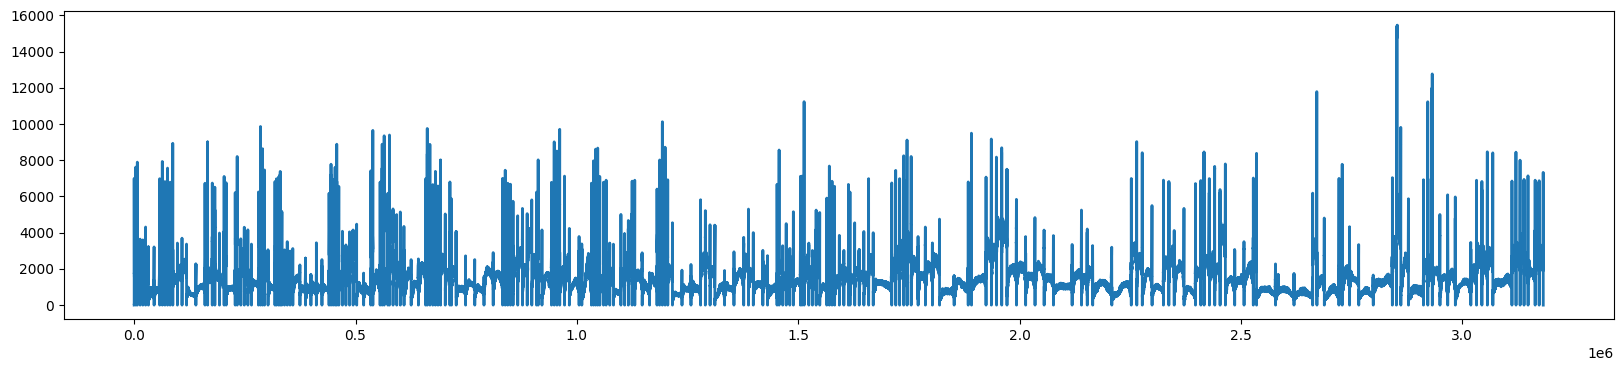

In [ ]:
df.index.freq = 'TimeMS'
df.shape
df.columns
plt.figure(figsize=(20, 4))
plt.plot(df.avg_current, linewidth=2)
plt.show()

In [ ]:
cols = ['id', 'TimeMS', 'Avg_Velocity', 'PWM_Output', 'SG_NoFilter', 'Setpoint', 'StrainGage', 'avg_current', 'current_filter', 'ticks', 'True_Endstop_Time_ms', 'Articulation', 'Tissue', 'Tissue_Thickness_inch', 'Firing_Type']

measures = ['Avg_Velocity', 'StrainGage', 'avg_current', 'PWM_Output', 'Anomaly_At_Time_ms', 'id', 'TimeMS']

for i in range(1,6):
  measure=measures[i-1]
  print(measure.title())
df=df[measures]

Avg_Velocity
Straingage
Avg_Current
Pwm_Output
Anomaly_At_Time_Ms


In [ ]:
df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,id,TimeMS
0,0.00,1,0,153,3360,100,0
1,0.00,2,0,165,3360,100,1
2,0.00,4,0,176,3360,100,2
3,0.00,5,0,188,3360,100,3
4,0.00,6,0,199,3360,100,4
...,...,...,...,...,...,...,...
3183005,93.75,128,0,0,4363,97,4642
3183006,62.50,128,0,0,4363,97,4643
3183007,62.50,128,0,0,4363,97,4643
3183008,31.25,128,0,0,4363,97,4644


In [ ]:
def plot_measure(df):
  e=np.unique(df['Anomaly_At_Time_ms'])[0]
  df=df[df.TimeMS > 400]
  #plt.plot('TimeMS','StrainGage',data=df)
  #plt.plot('TimeMS','Avg_Velocity',data=df)
  plt.figure(figsize=(16,12))
  for i in range(1,5):
    measure=measures[i-1]
    plt.subplot(2,2,i)
    plt.title(measure.title() + ' from a surgical instrument')
    # naming the x axis
    plt.xlabel('Time in Milliseconds')
    # naming the y axis
    plt.ylabel(measure.title())
    plt.plot('TimeMS',measure,data=df)
    #plt.plot('TimeMS','avg_current',data=df)
    plt.legend(loc="upper left")
    plt.axvline(e, color='r')
  plt.show()

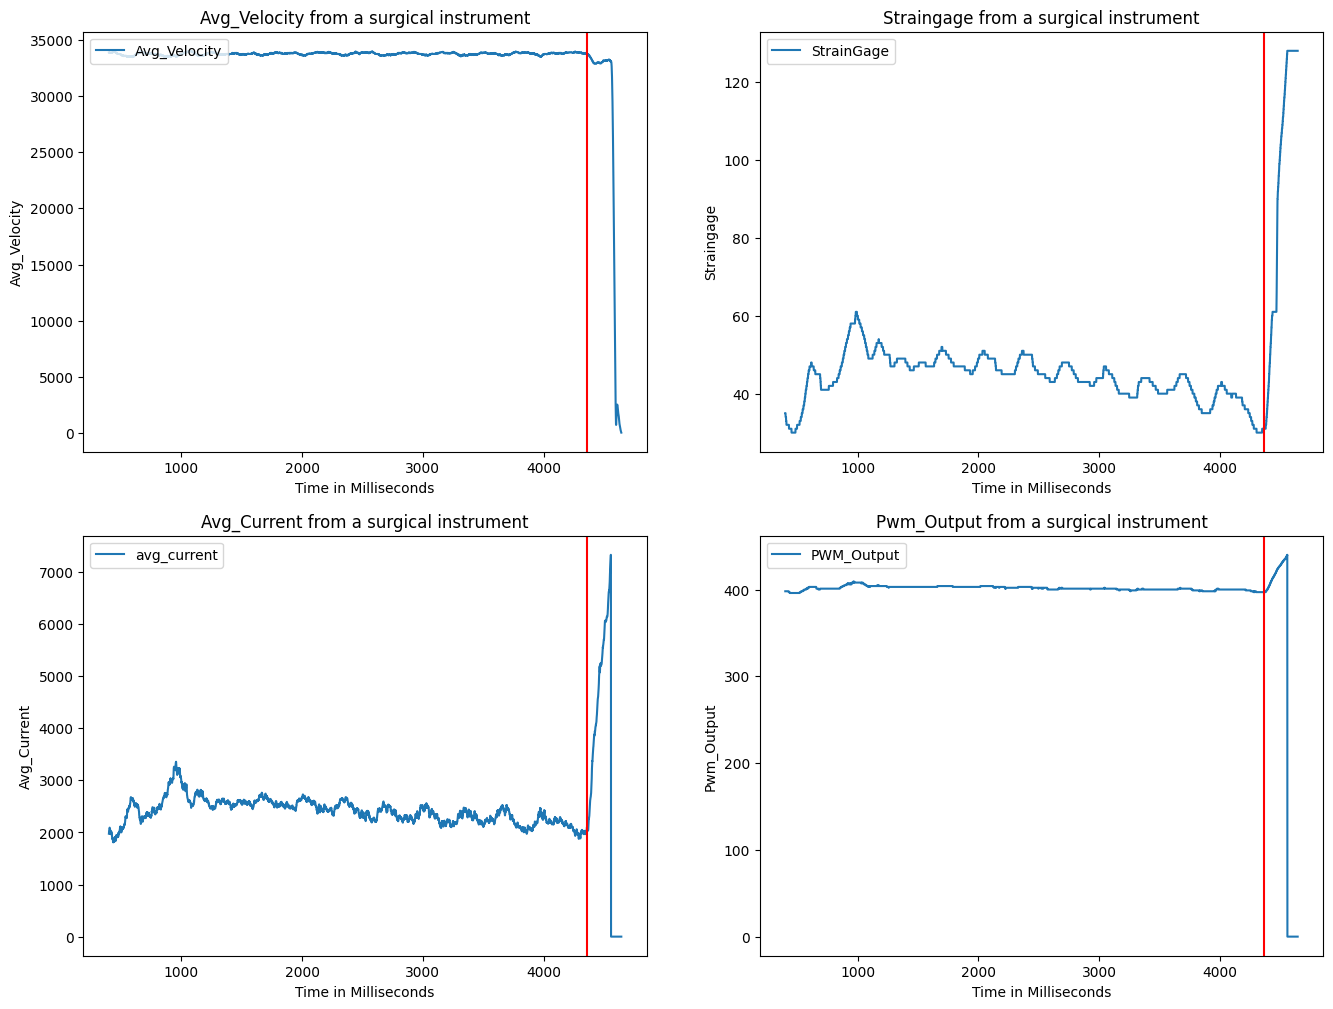

In [ ]:
df_97=df["id"]==97
plot_measure(df[df_97])

In [ ]:
df[['TimeMS','id']].groupby('id').count()

,TimeMS
id,
2,3764
3,3681
4,7436
5,7468
6,7376
...,...
366,12422
368,22102
370,12286


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences


#Pad sequences to ensure each 'id' has the same length as the maximum sequence length
max_seq_length = df[['TimeMS', 'id']].groupby('id').count().max().values[0]

# Create a dictionary to store sequences for each 'id' group
id_sequences = {}

# Group data by 'id' and store sequences in the dictionary
for id_group in df.groupby('id'):
    id_value, group_df = id_group
    sequence = group_df['TimeMS'].values
    id_sequences[id_value] = sequence

# Pad each sequence individually using the pad_sequences function for 'TimeMS'
padded_sequences = [pad_sequences([sequence], maxlen=max_seq_length, padding='pre', value=0)[0] for sequence in id_sequences.values()]

# Initialize a dictionary to store the padded sequences for each column
padded_data_dict = {}

# Pad each sequence individually using the pad_sequences function for other columns
for col in df.columns:
    if col not in ['TimeMS', 'id']:
        sequences = [group_df[col].values for _, group_df in df.groupby('id')]
        padded_sequences_col = [pad_sequences([sequence], maxlen=max_seq_length, padding='pre', value=0)[0] for sequence in sequences]
        padded_data_dict[col] = np.concatenate(padded_sequences_col, axis=0)

# Add 'Padded_TimeMS' column to the dictionary
padded_data_dict['Padded_TimeMS'] = np.concatenate(padded_sequences, axis=0)

# Add 'id' column to the dictionary
padded_data_dict['id'] = np.repeat(df['id'].unique(), max_seq_length)

# Create the final DataFrame with padded sequences for all columns
padded_df = pd.DataFrame(data=padded_data_dict)

# Now, 'padded_df' contains the data with padded sequences, and each 'id' has the same length as the maximum sequence length


In [ ]:
padded_df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,Padded_TimeMS,id
0,0,0,0,0,0,0,100
1,0,0,0,0,0,0,100
2,0,0,0,0,0,0,100
3,0,0,0,0,0,0,100
4,0,0,0,0,0,0,100
...,...,...,...,...,...,...,...
10991995,93,163,0,0,10522,11049,97
10991996,62,163,0,0,10522,11050,97
10991997,62,163,0,0,10522,11050,97
10991998,31,163,0,0,10522,11051,97


In [ ]:
padded_df[['Padded_TimeMS','id']].groupby('id').count()



,Padded_TimeMS
id,
2,43968
3,43968
4,43968
5,43968
6,43968
...,...
366,43968
368,43968
370,43968


In [ ]:
import pandas as pd

# Assuming your dataset is already loaded into the DataFrame called "padded_df"
# If not, you can load it from your data source using pd.read_csv or any other method.

# Add a new column "Label" and initialize it with 0
padded_df['Label'] = 0

# Update "Label" to 1 for rows where "Padded_TimeMS" is greater than "Anomaly_At_Time_ms"
padded_df.loc[padded_df['Padded_TimeMS'] > padded_df['Anomaly_At_Time_ms'], 'Label'] = 1




In [ ]:
padded_df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,Padded_TimeMS,id,Label
0,0,0,0,0,0,0,100,0
1,0,0,0,0,0,0,100,0
2,0,0,0,0,0,0,100,0
3,0,0,0,0,0,0,100,0
4,0,0,0,0,0,0,100,0
...,...,...,...,...,...,...,...,...
10991995,93,163,0,0,10522,11049,97,1
10991996,62,163,0,0,10522,11050,97,1
10991997,62,163,0,0,10522,11050,97,1
10991998,31,163,0,0,10522,11051,97,1


In [ ]:
#padded_df.to_csv("padded.csv", index=False)

In [ ]:
features = padded_df[['Avg_Velocity','StrainGage','avg_current','PWM_Output']]
label = padded_df['Label']

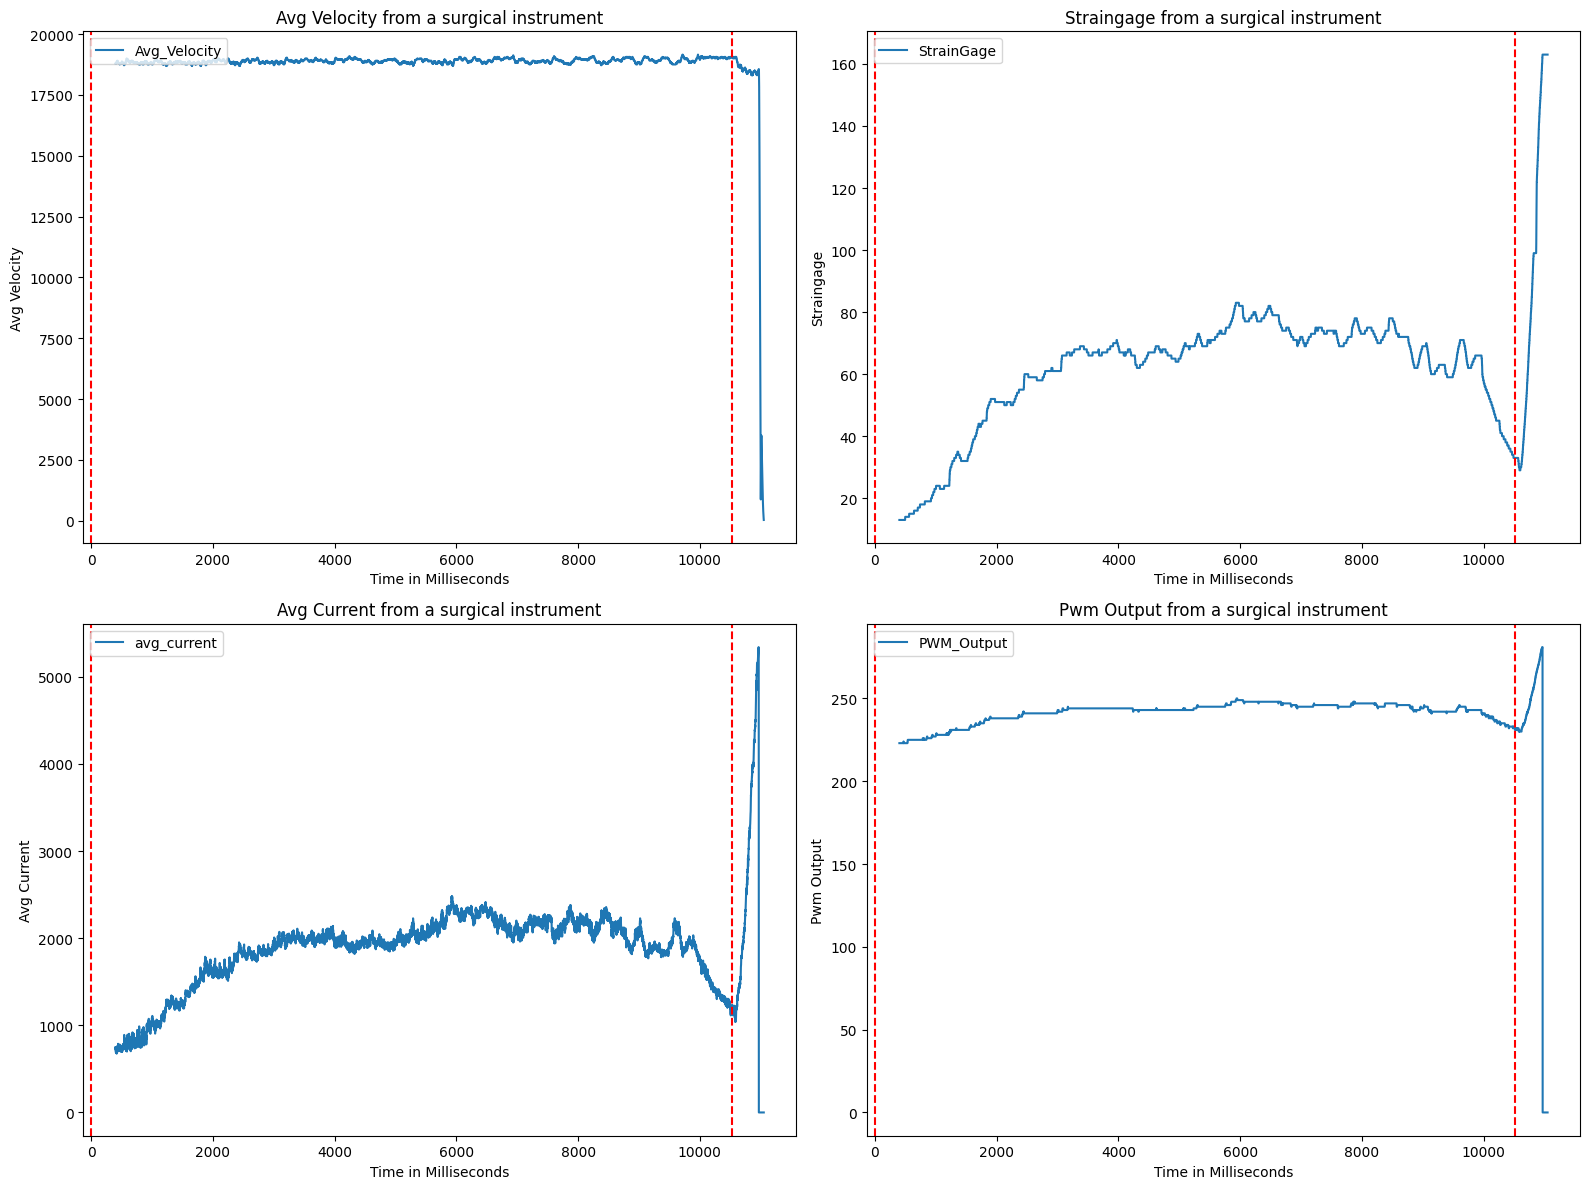

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_measure(padded_df):
    unique_times = np.unique(padded_df['Anomaly_At_Time_ms'])
    df = padded_df[padded_df['Padded_TimeMS'] > 400]

    plt.figure(figsize=(16, 12))

    for i, measure in enumerate(['Avg_Velocity', 'StrainGage', 'avg_current', 'PWM_Output']):
        plt.subplot(2, 2, i+1)
        plt.title(measure.replace('_', ' ').title() + ' from a surgical instrument')
        plt.xlabel('Time in Milliseconds')
        plt.ylabel(measure.replace('_', ' ').title())
        plt.plot('Padded_TimeMS', measure, data=df)

        # Add vertical lines for each unique Anomaly_At_Time_ms value
        for t in unique_times:
            plt.axvline(t, color='r', linestyle='--')

        plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

# Assuming you have the 'padded_df' DataFrame
padded_df_97 = padded_df[padded_df["id"] == 97]
plot_measure(padded_df_97)


In [ ]:
padded_df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,Padded_TimeMS,id,Label
0,0,0,0,0,0,0,100,0
1,0,0,0,0,0,0,100,0
2,0,0,0,0,0,0,100,0
3,0,0,0,0,0,0,100,0
4,0,0,0,0,0,0,100,0
...,...,...,...,...,...,...,...,...
10991995,93,163,0,0,10522,11049,97,1
10991996,62,163,0,0,10522,11050,97,1
10991997,62,163,0,0,10522,11050,97,1
10991998,31,163,0,0,10522,11051,97,1


In [ ]:
import numpy as np

# Separate features and labels for training and testing sets
#X = padded_df.drop(['Label', 'id', 'Anomaly_At_Time_ms', 'Padded_TimeMS'], axis=1)
X = padded_df[['StrainGage']]
Y = padded_df[['Label']]

# Convert data to numpy arrays
X_np = X.values
Y_np = Y.values.ravel()

# Separate normal and faulty samples
X_normal = X_np[Y_np == 0]
X_faulty = X_np[Y_np == 1]
Y_normal = Y_np[Y_np == 0]
Y_faulty = Y_np[Y_np == 1]

In [ ]:
# Determine the index to split between training and testing data
split_index = int(0.95 * len(X_normal))  # 80% for training, 20% for testing

# Split the data into training and testing sets
X_train = X_normal[:split_index]
X_test_1 = X_normal[split_index:]
Y_train = Y_normal[:split_index]
Y_test_1 = Y_normal[split_index:]

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test_1.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test_1.shape)


Shape of X_train: (10307978, 1)
Shape of X_test: (542526, 1)
Shape of Y_train: (10307978,)
Shape of Y_test: (542526,)


In [ ]:
# Combine X_test_1 and X_faulty to create a new combined test set
X_test= np.concatenate((X_test_1, X_faulty), axis=0)

# Create corresponding labels for the combined test set
Y_test = np.concatenate((np.zeros(len(X_test_1)), np.ones(len(X_faulty))), axis=0)

print("Shape of X_test_combined:", X_test.shape)
print("Shape of Y_test_combined:", Y_test.shape)


Shape of X_test_combined: (684022, 1)
Shape of Y_test_combined: (684022,)


In [ ]:
print(X_train.shape)
print(X_test.shape)

(10307978, 1)
(684022, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(10307978, 1)
(684022, 1)


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_inputs = 1024
n_features = 1
# Create generator for target data (Y_normal)
#target_generator_test = TimeseriesGenerator(Y_faulty, Y_faulty, length=n_inputs, batch_size=1024)

generator_train = TimeseriesGenerator(X_train_scaled, Y_train, length=n_inputs, batch_size=1024)
#generator_train = TimeseriesGenerator(X_train_scaled, Y_train, length=n_inputs, batch_size=len(X_train_scaled))

for i in range(len(generator_train)):
    x_normal, y_normal= generator_train[i]
    print(f'\n {x_normal.flatten()} and {y_normal}')

Streaming output truncated to the last 5000 lines.
 [1.62037181 1.62037181 1.62037181 ... 1.79269756 1.79269756 1.79269756] and [0 0 0 ... 0 0 0]

 [1.40496463 1.40496463 1.40496463 ... 1.87886043 1.87886043 1.87886043] and [0 0 0 ... 0 0 0]

 [1.79269756 1.79269756 1.79269756 ... 2.22351192 2.22351192 2.22351192] and [0 0 0 ... 0 0 0]

 [1.87886043 1.87886043 1.87886043 ... 2.3096748  2.3096748  2.3096748 ] and [0 0 0 ... 0 0 0]

 [2.22351192 2.22351192 2.22351192 ... 2.26659336 2.26659336 2.26659336] and [0 0 0 ... 0 0 0]

 [2.3096748  2.3096748  2.3096748  ... 2.05118618 2.05118618 2.05118618] and [0 0 0 ... 0 0 0]

 [2.26659336 2.26659336 2.26659336 ... 2.18043049 2.18043049 2.18043049] and [0 0 0 ... 0 0 0]

 [2.05118618 2.05118618 2.05118618 ... 2.00810474 2.00810474 2.00810474] and [0 0 0 ... 0 0 0]

 [2.18043049 2.18043049 2.18043049 ... 2.05118618 2.05118618 2.05118618] and [0 0 0 ... 0 0 0]

 [2.00810474 2.00810474 2.00810474 ... 2.22351192 2.22351192 2.22351192] and [0 0 0 .

In [ ]:
print(x_normal.shape)
print(y_normal.shape)

(394, 1024, 1)
(394,)


In [ ]:
n_inputs = 1024
batch_size = 1024
n_features = 1
# Step 1: Separate the normal (0) and anomalous (1) signals
X_test_normal = X_test_scaled[Y_test == 0]
Y_test_normal = Y_test[Y_test == 0]

X_test_anomalous = X_test_scaled[Y_test == 1]
Y_test_anomalous = Y_test[Y_test == 1]


In [ ]:
print(X_test_normal.shape)
print(X_test_anomalous.shape)

(542526, 1)
(141496, 1)


In [ ]:
# Step 2: Create two separate generators for normal and anomalous signals
generator_normal = TimeseriesGenerator(X_test_normal, Y_test_normal, length=n_inputs, batch_size=len(X_test_normal))
generator_anomalous = TimeseriesGenerator(X_test_anomalous, Y_test_anomalous, length=n_inputs, batch_size=len(X_test_anomalous))
#generator_normal = TimeseriesGenerator(X_test_normal, Y_test_normal, length=n_inputs, batch_size=128)
#generator_anomalous = TimeseriesGenerator(X_test_anomalous, Y_test_anomalous, length=n_inputs, batch_size=128)

# Step 3: Extract the normal and anomalous batches from the generators
x_test_normal, _ = generator_normal[0]
x_test_anomalous, _ = generator_anomalous[0]

In [ ]:
x_test_normal.shape

(541502, 1024, 1)

In [ ]:
x_test_anomalous.shape

(140472, 1024, 1)

In [ ]:
#Flattening the x
x_normal_r = x_normal.reshape((x_normal.shape[0], -1))
x_test_normal_r = x_test_normal.reshape((x_test_normal.shape[0], -1))
x_test_anomalous_r = x_test_anomalous.reshape((x_test_anomalous.shape[0], -1))

In [ ]:
x_normal_r.shape

(394, 1024)

In [ ]:
x_normal_r.shape

(394, 1024)

In [ ]:
original_dim = x_normal_r.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 4)
latent_dim = int(original_dim / 32)

In [ ]:
# The reparameterization trick
from tensorflow.math import reduce_prod

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# VAE model
def build_vae(input_dim, intermediate_dim, latent_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(intermediate_dim, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(intermediate_dim, activation='relu')(x)
    x = Dropout(0.3)(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    z = Lambda(sampling)([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z])

    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    x = Dropout(0.3)(x)
    x = Dense(intermediate_dim, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(input_dim, activation='sigmoid')(x)

    decoder = Model(latent_inputs, outputs)

    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs)

    def vae_loss(y_true, y_pred):
      reconstruction_loss = K.mean(K.square(y_true - y_pred), axis=-1)
      kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
      beta = 4  # Adjust this value to control the balance
      return reconstruction_loss + beta * kl_loss


    vae.compile(optimizer=Adam(learning_rate=0.001), loss=vae_loss)

    return vae, encoder, decoder



In [ ]:
# Build and train the model
input_dim = x_normal_r.shape[1]
intermediate_dim = 256
latent_dim = 64

vae, encoder, decoder = build_vae(input_dim, intermediate_dim, latent_dim)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = vae.fit(
    x_normal_r, x_normal_r,
    epochs=200,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks
)

Train on 315 samples, validate on 79 samples
Epoch 1/200
128/315 [===========>..................] - ETA: 0s - loss: 1.9264

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


315/315 [==============================] - 1s 2ms/sample - loss: 1.4894 - val_loss: 1.0121 - lr: 0.0010
Epoch 2/200
315/315 [==============================] - 0s 192us/sample - loss: 0.9847 - val_loss: 0.8557 - lr: 0.0010
Epoch 3/200
315/315 [==============================] - 0s 196us/sample - loss: 0.7998 - val_loss: 0.6681 - lr: 0.0010
Epoch 4/200
315/315 [==============================] - 0s 202us/sample - loss: 0.6140 - val_loss: 0.4788 - lr: 0.0010
Epoch 5/200
315/315 [==============================] - 0s 192us/sample - loss: 0.4402 - val_loss: 0.3555 - lr: 0.0010
Epoch 6/200
315/315 [==============================] - 0s 205us/sample - loss: 0.3410 - val_loss: 0.3058 - lr: 0.0010
Epoch 7/200
315/315 [==============================] - 0s 202us/sample - loss: 0.3032 - val_loss: 0.2916 - lr: 0.0010
Epoch 8/200
315/315 [==============================] - 0s 220us/sample - loss: 0.2906 - val_loss: 0.2868 - lr: 0.0010
Epoch 9/200
315/315 [==============================] - 0s 189us/sample

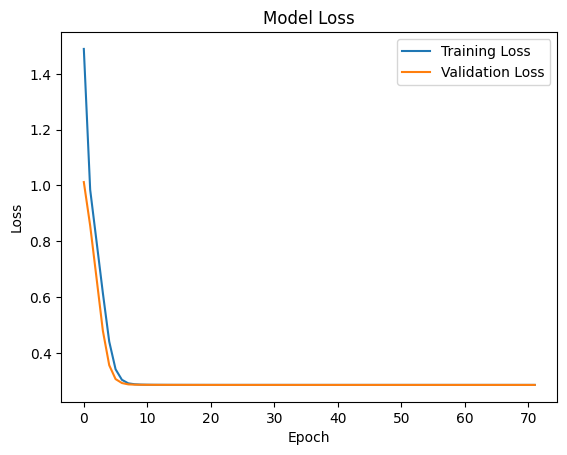

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [ ]:
X_normal_pred = vae.predict(x_normal_r)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
X_normal_pred.shape

(394, 1024)

In [ ]:
mae_vector = get_error_term(X_normal_pred, x_normal_r, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.5337173657117881
median error 0.5337077381492132
99Q: 0.5338554888198304
setting threshold on 0.5338554888198304 


In [ ]:
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def calculate_reconstruction_error(model, data, batch_size=1024):
    reconstruction_errors = []
    for i in tqdm(range(0, len(data), batch_size)):
        batch = data[i:i+batch_size]
        reconstructed = model.predict(batch)
        error = np.mean(np.square(batch - reconstructed), axis=1)
        reconstruction_errors.extend(error)
    return np.array(reconstruction_errors)

# Calculate reconstruction errors
print("Calculating reconstruction errors for normal data...")
normal_errors = calculate_reconstruction_error(vae, x_test_normal_r)
print("Calculating reconstruction errors for anomalous data...")
anomalous_errors = calculate_reconstruction_error(vae, x_test_anomalous_r)

Calculating reconstruction errors for normal data...


100%|██████████| 529/529 [01:10<00:00,  7.46it/s]


Calculating reconstruction errors for anomalous data...


100%|██████████| 138/138 [00:12<00:00, 11.12it/s]


In [ ]:
# Combine errors and labels
all_errors = np.concatenate([normal_errors, anomalous_errors])
all_labels = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomalous_errors))])

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_errors)
roc_auc = auc(fpr, tpr)

# Calculate precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_errors)

# Find the best threshold
best_f1 = 0
best_threshold = 0
for p, r, t in zip(precision, recall, pr_thresholds):
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold: {best_threshold}")
print(f"Best F1 score: {best_f1}")
print(f"AUC: {roc_auc}")


Best threshold: 6.9241686123715125
Best F1 score: 0.9212608483300146
AUC: 0.9901188988841587


In [ ]:
# Apply best threshold
y_pred = (all_errors > best_threshold).astype(int)

# Calculate final metrics
accuracy = np.mean(all_labels == y_pred)
true_positives = np.sum((all_labels == 1) & (y_pred == 1))
false_positives = np.sum((all_labels == 0) & (y_pred == 1))
false_negatives = np.sum((all_labels == 1) & (y_pred == 0))

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9692671568124298
Precision: 0.9754011631144737
Recall: 0.8728073922205137


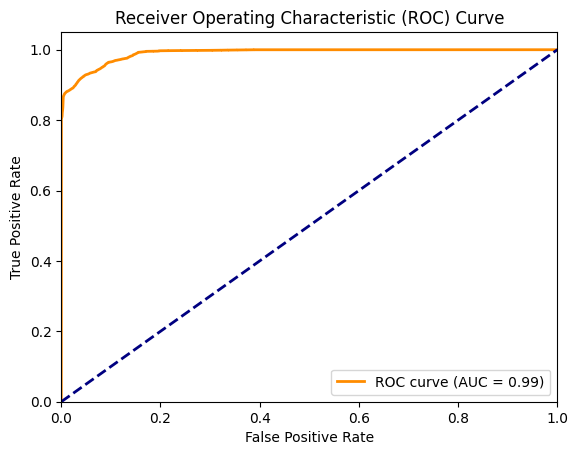

In [ ]:
# Optional: Plot ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Generate classification report
class_names = ['Normal', 'Anomalous']
print("\nClassification Report:")
print(classification_report(all_labels, y_pred, target_names=class_names))




Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98    541502
   Anomalous       0.98      0.87      0.92    140472

    accuracy                           0.97    681974
   macro avg       0.97      0.93      0.95    681974
weighted avg       0.97      0.97      0.97    681974

